In [1]:
import tensorflow as tf

from truesight.preprocessing import Preprocessor
from truesight.core import TrueSight
from truesight.metrics import Evaluator, mse, rmse, mae
from truesight.utils import get_input_shapes, generate_syntetic_data

In [2]:
num_time_steps = 100
season_length = 12
forecast_horizon = 12
df = generate_syntetic_data(num_time_steps, season_length, num_series=100)

In [3]:
from statsforecast.models import SeasonalNaive, AutoETS
from sklearn.linear_model import LinearRegression
from truesight.models import AdditiveDecomposition
from truesight.utils import ModelWrapper

models = [
    ModelWrapper(LinearRegression, horizon=forecast_horizon, season_length=season_length), 
    ModelWrapper(SeasonalNaive, horizon=forecast_horizon, season_length=season_length), 
    ModelWrapper(AutoETS, horizon=forecast_horizon, season_length=season_length),
    ModelWrapper(AdditiveDecomposition, horizon=forecast_horizon, season_length=season_length)
]

preprocessor = Preprocessor(df)
X_train, Y_train, ids_train, X_val, Y_val, ids_val, models = preprocessor.make_dataset(
    forecast_horizon = 12, 
    season_length = 12,
    date_freq = "MS", 
    models = models, 
    fallback_model = ModelWrapper(SeasonalNaive, horizon=forecast_horizon, season_length=season_length),
    verbose = True
    )

100%|██████████| 20/20 [00:01<00:00, 19.26it/s]


In [13]:
input_shapes = get_input_shapes(X_train)
truesight = TrueSight(models, input_shapes, forecast_horizon = forecast_horizon)

In [ ]:
truesight.auto_tune(X_train, Y_train, X_val, Y_val, n_trials = 10, batch_size = 512, epochs = 5)

In [14]:
truesight.set_hparams(lstm_units=256, hidden_size=1024, num_heads=8, dropout_rate=0.1)

Train the model

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


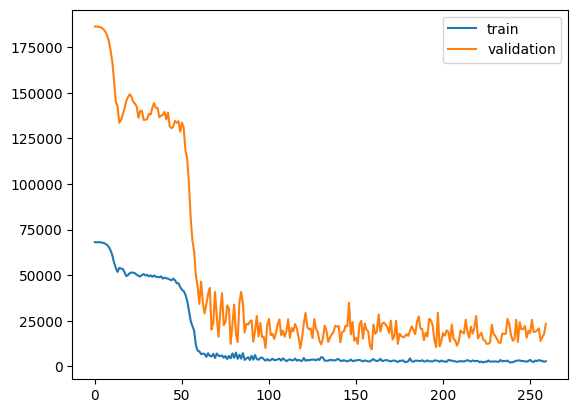

In [15]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 100, restore_best_weights = True, monitor = "val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 25, verbose = False),
]
truesight.fit(X_train, Y_train, X_val, Y_val, batch_size = 128, epochs = 1000, verbose = False, callbacks = callbacks)
truesight.plot_history()

Evaluate the results

In [16]:
Y_hat = truesight.predict(X_val, batch_size = 500, n_repeats = 100, n_quantiles = 15, return_quantiles = True, verbose = False)
evaluator = Evaluator(X_val, Y_val, Y_hat, ids_val)
print(evaluator.evaluate_prediction([mse, rmse, mae], return_mean=False).to_markdown())

|    |          mse |      rmse |       mae |
|---:|-------------:|----------:|----------:|
|  5 |     17.865   |   4.2267  |   3.51082 |
|  7 |     18.1695  |   4.26257 |   3.46075 |
|  8 |  13428.3     | 115.88    | 104.873   |
| 22 |      4.33293 |   2.08157 |   1.59566 |
| 31 | 170566       | 412.997   | 394.816   |
| 34 |     53.7989  |   7.33477 |   3.72646 |
| 40 |   2451.96    |  49.5173  |  41.5288  |
| 41 |      5.42232 |   2.32859 |   1.8383  |
| 42 |   1883.26    |  43.3965  |  36.828   |
| 43 |   1257.34    |  35.459   |  29.3341  |
| 51 |    262.735   |  16.2091  |  11.2244  |
| 61 |   3256.58    |  57.0665  |  45.4854  |
| 62 |  12737.3     | 112.86    |  86.9254  |
| 77 |   4324.08    |  65.7577  |  51.7756  |
| 78 |  85269.9     | 292.01    | 285.206   |
| 81 |    140.199   |  11.8406  |   9.75169 |
| 83 |    830.233   |  28.8138  |  23.2007  |
| 89 |   8114.91    |  90.0828  |  71.2809  |
| 94 |   1959.09    |  44.2616  |  36.8832  |
| 95 |    997.579   |  31.5845  | 

Visualize individual inputs

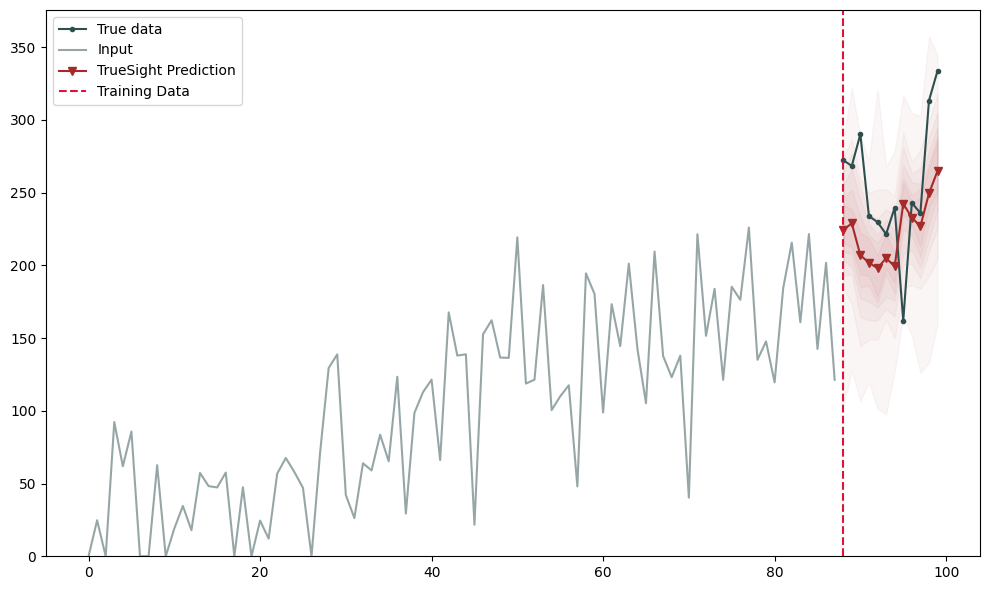

In [33]:
evaluator.plot_exemple()